In [ ]:
"""
inpute = Raw datasets
outputs = KeplerGl datasets, pandas bokeh time sliders



"""

In [1]:
"""
This Part can tune Multi threading

n_workers = Number of CPU cores
memory_limit = limitation of memory for each worker

Becareful about choosing number of workers some time its better to reduce number of workers due to memory limitations

Tune partitioning or number of partitions can help multi threading process and may reduce memory overheading

"""
#This part is very very tricky for this datasets. Generally spatial join is very very memory consuming process! Becareful about block sizes!

from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, 
                       threads_per_worker=2,
                       memory_limit='4GB')
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:3920 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 12 Memory: 24.00 GB


# import libraries

In [2]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# import datasets

In [5]:
data = dd.read_csv(r'E:\Arshad\Thesis\Datasets\Test samples\Sample1.csv',parse_dates=['Date_Time'])

# filter data frames

In [6]:
data['Hour'] = data.Date_Time.dt.hour
data_filteredbyH = data[(data.Hour>=6) & (data.Hour<=24)]
data_gbyH = data_filteredbyH.groupby('Hour')

# spatial Join

In [12]:
def custom_join(df):
    
    shp1 = gpd.read_file(r'E:\Arshad\Thesis\Datasets\Shapefiles\Tehran Mahalat\mahalat.shp') #send this for mr Rahmani
    shp = shp1.to_crs({'init': 'epsg:4326'})
    geodf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.Long, y=df.Lat), crs={'init': 'epsg:4326'})
    joined_data =gpd.sjoin(geodf, shp, how='left',op='within')
    joined_data = pd.DataFrame(joined_data)
    output = joined_data.groupby('index_right')['REGION'].count().reset_index()
    
    return output

In [13]:
#here will spatial join and count each antenna per Mahale

countPerMahale = data_gbyH.apply(custom_join,meta={'index_right':np.int64,'REGION':np.int64}).compute()

# Plotting

In [15]:

#in this part we merge data sets by their indexes(geodataframe vs count of antenna in each mahale)
#when you spatial join your dataframe this action will add two extra columns.One is indexes the other is georef labels. Because of this I decided to use indexes to merge countPrerMahale and Mahalat shapefiles

shp1 = gpd.read_file(r'E:\Arshad\Thesis\Datasets\Shapefiles\Tehran Mahalat\mahalat.shp')
shp = shp1.to_crs({'init': 'epsg:4326'})
Hours ={}
shp['index_right'] = range(0,353)


for i in range(6,24):
    
    
    Merged_shp = shp.merge(countPerMahale.loc[i],on='index_right',how='outer')
    Merged_shp.fillna(0,inplace=True)
    Hours['{}'.format(i)]=Merged_shp
    
    
    
    

C:\Users\Asus\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
#This will plot simple map of mahalat which colors are changing by the numbers of antenna in that Mahale.

for i in range(6,24):
    plt.figure()
    Hours['{}'.format(i)].plot(figsize=(17,17), edgecolor="grey",cmap='OrRd',column='REGION_y',alpha=0.8)
    plt.title('Hour {}'.format(i))

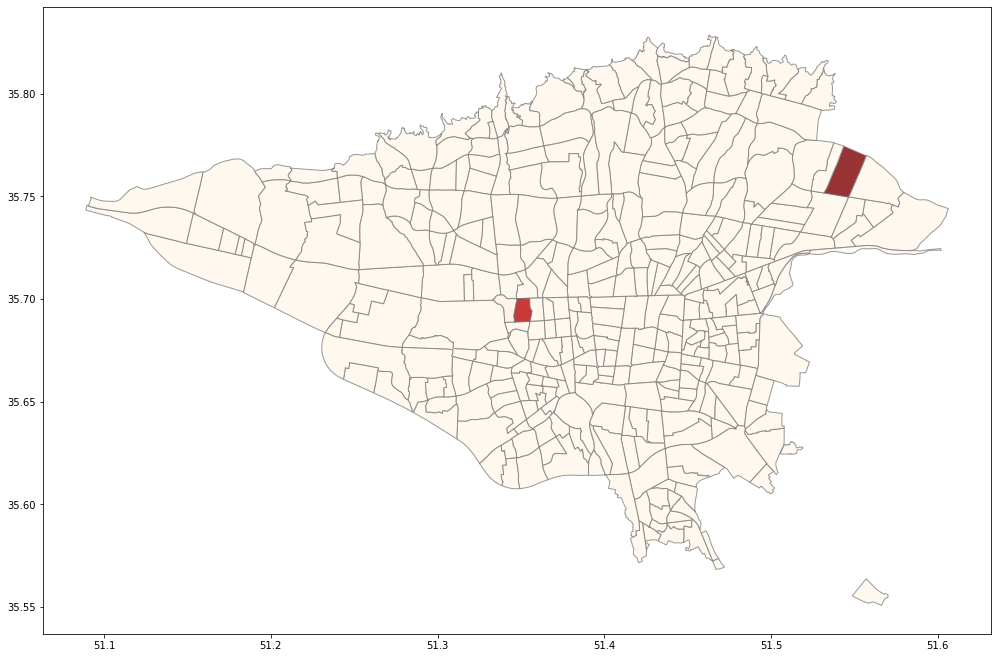

In [16]:

#This is a simple Plot for checking
Hours['22'].plot(figsize=(17,17), edgecolor="grey",cmap='OrRd',column='REGION_y',alpha=0.8)

In [17]:
#create dataframe for pandas bokeh
l=[]
for i in range(6,24):
    shp['Hour {} Activity'.format(i)] = Hours['{}'.format(i)]['REGION_y']
    l.append('Hour {} Activity'.format(i))
    

# Prepairing Kepler datasets

In [18]:
#this is for keplergl
ll=[]
for i in range(6,24):
    ddf=Hours['{}'.format(i)] 
    ddf['Time'] = pd.to_datetime('2019 {}:00:00'.format(i))
    ll.append(ddf)
df_keplergl=pd.concat(ll).reset_index()
df_keplergl

,index,REGION_x,NAME_MAHAL,CODE,OLD_CODE,NAME_REGIO,ENAME,ID,AREA,ESRI_OID,geometry,index_right,REGION_y,Time
0,0,1.0,کاشانک,109,5721469,کاشانک1,Kashanak,1,2.450775e+06,1,"POLYGON ((51.48393 35.81890, 51.48397 35.81874...",0,1.0,2019-01-01 06:00:00
1,1,1.0,دارآباد,110,5721472,دارآباد1,Darabad,2,1.938397e+06,2,"POLYGON ((51.49558 35.81765, 51.49553 35.81762...",1,0.0,2019-01-01 06:00:00
2,2,1.0,هزارسنگ,127,1128,هزارسنگ1,Hezar sang,4,1.236379e+05,3,"POLYGON ((51.37782 35.80783, 51.37852 35.80725...",2,0.0,2019-01-01 06:00:00
3,3,1.0,ولنجک,103,5721463,ولنجک1,Velenjak,3,2.524723e+06,4,"POLYGON ((51.41223 35.79764, 51.41189 35.79750...",3,0.0,2019-01-01 06:00:00
4,4,2.0,پرواز,202,5721016,پرواز2,Parvaz,5,1.209150e+06,5,"POLYGON ((51.35680 35.79625, 51.35680 35.79625...",4,0.0,2019-01-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6349,348,5.0,انديشه,518,5720722,انديشه5,Andisheh,63,2.640711e+06,349,"POLYGON ((51.28791 35.75330, 51.28942 35.75323...",348,0.0,2019-01-01 23:00:00
6350,349,14.0,قصرفيروزه,1406,5721610,قصرفيروزه14,Qasr Firuzeh,160,7.389096e+06,350,"POLYGON ((51.50193 35.66018, 51.50173 35.66020...",349,0.0,2019-01-01 23:00:00
6351,350,18.0,شهيد رجايي,1816,5721085,شهيد رجايي18,Shahid Rajaie,313,4.993914e+06,351,"POLYGON ((51.34569 35.63671, 51.34569 35.63671...",350,0.0,2019-01-01 23:00:00
6352,351,13.0,سرخه حصار,1306,5721283,سرخه حصار13,Sorkheh Hesar,324,1.386776e+06,352,"POLYGON ((51.56701 35.72471, 51.56809 35.72453...",351,0.0,2019-01-01 23:00:00


In [19]:
l

['Hour 6 Activity',
 'Hour 7 Activity',
 'Hour 8 Activity',
 'Hour 9 Activity',
 'Hour 10 Activity',
 'Hour 11 Activity',
 'Hour 12 Activity',
 'Hour 13 Activity',
 'Hour 14 Activity',
 'Hour 15 Activity',
 'Hour 16 Activity',
 'Hour 17 Activity',
 'Hour 18 Activity',
 'Hour 19 Activity',
 'Hour 20 Activity',
 'Hour 21 Activity',
 'Hour 22 Activity',
 'Hour 23 Activity']

# Pandas Bokeh for timelines

In [21]:
import pandas_bokeh
pandas_bokeh.output_notebook()
#pandas_bokeh.output_file("Interactive Plot.html") this is for saving
#teh1 = gpd.read_file('E:tehrn.shp')
#teh = teh1.to_crs({'init': 'epsg:4326'})
from bokeh.palettes import brewer
c = brewer['Reds'][8]
c = c[::-1]


Loading BokehJS ...

In [22]:
#Calculate change of population relative to 2010:
#l

#Specify slider columns:
slider_columns = l

slider_range = range(6, 24)

#Make slider plot:
shp.plot_bokeh(
    figsize=(900, 600),
    slider=slider_columns,
    slider_range=slider_range,
    slider_name="Hour", 
    colormap=c,
    hovertool_columns=["ENAME"] + slider_columns,
    title="No of Activity",alpha = 0.8)

Column(id='1073', ...)

# KeplerGl

In [25]:
df_keplergl.to_csv('E:file.csv',index=True)

import this df to this url:https://kepler.gl/demo

In [23]:
from keplergl import KeplerGl
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

In [24]:
KeplerGl(height=500,data={'Census Data':df_keplergl})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Census Data':       index  REGION_x  NAME_MAHAL  CODE OLD_CODE    NAME_REGIO          ENAME  \…